
# ENEM 2023 — Pré-processamento & EDA inicial

Este notebook guia você pelos passos de **checagem, limpeza leve e exploração inicial** da base preparada do ENEM 2023 (`data/interim/enem_2023.parquet`).  
A ideia é **aprender fazendo**: cada seção tem explicações curtas e células que você pode rodar e adaptar.

> Dica: Sempre rode **Kernel → Restart & Run All** antes de salvar, para garantir reprodutibilidade.


In [1]:

# Imports principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 120)



## 1. Carregar a base preparada (Parquet)

O Parquet é gerado pela *stage* `prepare_2023` do DVC e já contém:
- notas (`NU_NOTA_*`), 
- campos socioeconômicos (ex.: `Q001`, `Q002`, `Q006`, `Q022`, `Q024`, `Q025`), 
- `TP_ESCOLA` e `SG_UF_RESIDENCIA`,
- coluna agregada `NOTA_MEDIA_5`.

Se o arquivo estiver em outro caminho, ajuste `PARQUET_PATH`.


In [3]:
from pathlib import Path

PARQUET_PATH = Path("../data/interim/enem_2023.parquet").resolve()
df = pd.read_parquet(PARQUET_PATH)
df.head()


,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_REDACAO,TP_ESCOLA,Q001,Q002,Q006,Q022,Q024,Q025,IN_TREINEIRO,NOTA_MEDIA_5,Q001_ord,Q002_ord,Q006_ord,Q022_ord,Q024_ord,Q025_ord
0,363.2,475.6,498.9,502.0,700.0,1,H,E,C,A,A,B,0,507.94,8,5,3,1,1,2
1,466.7,507.2,508.5,459.0,880.0,2,D,D,C,D,A,B,0,564.28,4,4,3,4,1,2
2,338.3,446.9,379.2,402.5,560.0,2,B,B,B,B,A,A,0,425.38,2,2,2,2,1,1
3,680.2,610.4,630.3,564.7,600.0,1,H,E,F,C,B,B,0,617.12,8,5,6,3,2,2
4,736.3,626.9,620.2,644.9,860.0,1,F,C,B,E,B,B,0,697.66,6,3,2,5,2,2


## 2. Visão geral
Tamanho do dataset, tipos de dados e amostra.

In [4]:

print("Shape:", df.shape)
print("\nTipos:")
print(df.dtypes.head(20))

print("\nAmostra aleatória:")
display(df.sample(5, random_state=42))


Shape: (2166843, 20)

Tipos:
NU_NOTA_MT         float64
NU_NOTA_LC         float64
NU_NOTA_CH         float64
NU_NOTA_CN         float64
NU_NOTA_REDACAO    float64
TP_ESCOLA            int64
Q001                object
Q002                object
Q006                object
Q022                object
Q024                object
Q025                object
IN_TREINEIRO         int64
NOTA_MEDIA_5       float64
Q001_ord             int64
Q002_ord             int64
Q006_ord             int64
Q022_ord             int64
Q024_ord             int64
Q025_ord             int64
dtype: object

Amostra aleatória:


,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_REDACAO,TP_ESCOLA,Q001,Q002,Q006,Q022,Q024,Q025,IN_TREINEIRO,NOTA_MEDIA_5,Q001_ord,Q002_ord,Q006_ord,Q022_ord,Q024_ord,Q025_ord
612669,335.2,424.8,375.6,476.0,0.0,2,A,B,B,C,A,B,0,322.32,1,2,2,3,1,2
1762769,635.0,571.1,600.2,584.4,660.0,2,H,E,E,D,C,B,0,610.14,8,5,5,4,3,2
1107526,528.5,504.8,536.5,432.8,560.0,2,A,E,B,B,A,B,0,512.52,1,5,2,2,1,2
1676798,603.3,522.0,536.6,533.5,560.0,1,E,E,C,D,A,B,0,551.08,5,5,3,4,1,2
328580,396.9,489.9,548.0,398.8,520.0,2,E,E,F,E,B,B,0,470.72,5,5,6,5,2,2



## 3. Valores ausentes (missing values)

Vamos medir a proporção de `NaN` por coluna e visualizar as **top 20** mais afetadas.


In [5]:

miss = df.isna().mean().sort_values(ascending=False)
miss.head(20)


NU_NOTA_MT         0.0
NU_NOTA_LC         0.0
Q024_ord           0.0
Q022_ord           0.0
Q006_ord           0.0
Q002_ord           0.0
Q001_ord           0.0
NOTA_MEDIA_5       0.0
IN_TREINEIRO       0.0
Q025               0.0
Q024               0.0
Q022               0.0
Q006               0.0
Q002               0.0
Q001               0.0
TP_ESCOLA          0.0
NU_NOTA_REDACAO    0.0
NU_NOTA_CN         0.0
NU_NOTA_CH         0.0
Q025_ord           0.0
dtype: float64

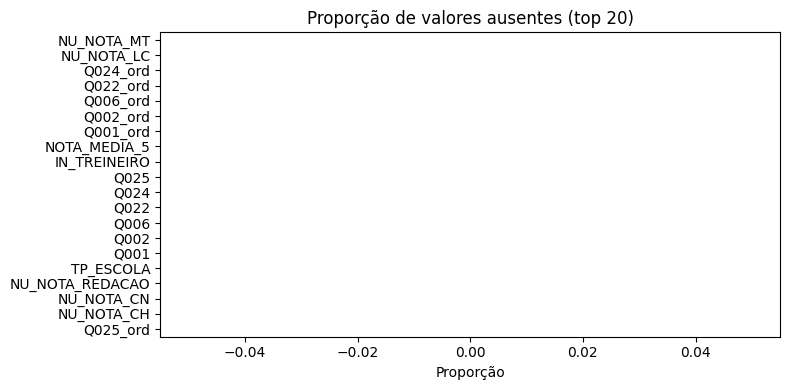

In [10]:

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
miss.head(20)[::-1].plot(kind="barh")
plt.title("Proporção de valores ausentes (top 20)")
plt.xlabel("Proporção")
plt.tight_layout()
plt.show()



## 4. Duplicatas

Checagem simples de linhas duplicadas totais. Ajuste `subset` para colunas-chave, se necessário.


In [6]:

dup_total = df.duplicated().sum()
print(f"Linhas duplicadas (todas as colunas): {dup_total}")
dup_subset = df.duplicated(subset=["SG_UF_RESIDENCIA","TP_ESCOLA"]).sum() if set(["SG_UF_RESIDENCIA","TP_ESCOLA"]).issubset(df.columns) else 0
print(f"Duplicadas por [SG_UF_RESIDENCIA, TP_ESCOLA]: {dup_subset}")


Linhas duplicadas (todas as colunas): 0
Duplicadas por [SG_UF_RESIDENCIA, TP_ESCOLA]: 0



## 5. Estatísticas de notas

Resumo descritivo das cinco notas e da média agregada.


In [7]:

nota_cols = [c for c in ["NU_NOTA_MT","NU_NOTA_LC","NU_NOTA_CH","NU_NOTA_CN","NU_NOTA_REDACAO","NOTA_MEDIA_5"] if c in df.columns]
df[nota_cols].describe().round(2)


,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_REDACAO,NOTA_MEDIA_5
count,2166843.00,2166843.00,2166843.00,2166843.00,2166843.00,2166843.00
mean,532.23,520.49,527.01,496.95,625.85,540.51
std,132.15,75.06,88.04,88.33,208.86,96.52
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,428.60,472.90,470.60,440.50,520.00,474.28
50%,519.70,524.50,533.30,494.00,620.00,537.70
75%,628.10,572.60,588.60,552.00,780.00,606.44
max,958.60,820.80,823.00,868.40,1000.00,862.58


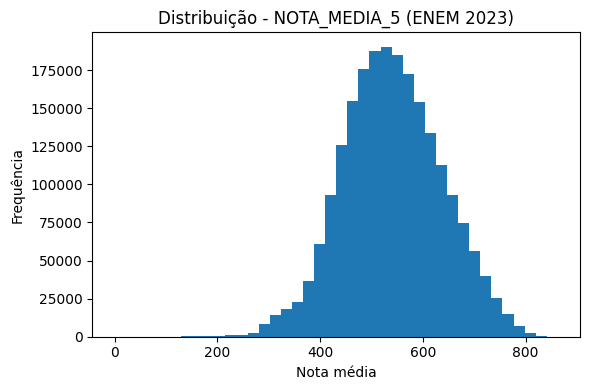

In [13]:

plt.figure(figsize=(6,4))
df["NOTA_MEDIA_5"].plot(kind="hist", bins=40)
plt.title("Distribuição - NOTA_MEDIA_5 (ENEM 2023)")
plt.xlabel("Nota média")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()



## 6. Outliers (IQR)

Usamos o critério **IQR** (Q3 + 1.5*IQR para alto; Q1 - 1.5*IQR para baixo) na `NOTA_MEDIA_5` como exemplo.


In [8]:

col = "NOTA_MEDIA_5"
q1, q3 = df[col].quantile([0.25, 0.75])
iqr = q3 - q1
low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
print(f"{col}: Q1={q1:.2f} | Q3={q3:.2f} | IQR={iqr:.2f} | low={low:.2f} | high={high:.2f}")
print("Acima do limite alto:", (df[col] > high).sum(), "| Abaixo do limite baixo:", (df[col] < low).sum())


NOTA_MEDIA_5: Q1=474.28 | Q3=606.44 | IQR=132.16 | low=276.04 | high=804.68
Acima do limite alto: 1396 | Abaixo do limite baixo: 6967


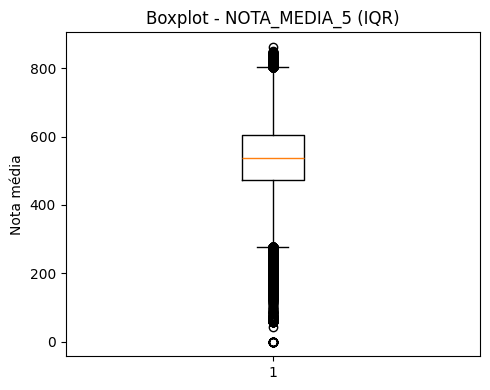

In [15]:

plt.figure(figsize=(5,4))
plt.boxplot(df["NOTA_MEDIA_5"].dropna().values, vert=True, showfliers=True)
plt.title("Boxplot - NOTA_MEDIA_5 (IQR)")
plt.ylabel("Nota média")
plt.tight_layout()
plt.show()



## 7. Bivariada: `TP_ESCOLA` × `NOTA_MEDIA_5`

Comparação de distribuição por tipo de escola.


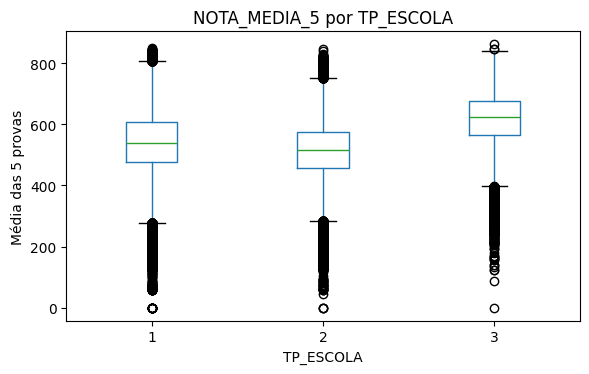

In [9]:

if "TP_ESCOLA" in df.columns:
    ax = df.boxplot(column="NOTA_MEDIA_5", by="TP_ESCOLA", grid=False, figsize=(6,4))
    plt.title("NOTA_MEDIA_5 por TP_ESCOLA")
    plt.suptitle("")
    plt.xlabel("TP_ESCOLA")
    plt.ylabel("Média das 5 provas")
    plt.tight_layout()
    plt.show()
else:
    print("TP_ESCOLA não encontrado na base.")



## 8. Tendência: renda (Q006) × `NOTA_MEDIA_5` (proxy ordinal)

Sem aplicar rótulos do dicionário ainda, mapeamos `A..Z → 1..26` para ver a tendência geral.
Depois, podemos substituir pelos rótulos oficiais lendo o dicionário.


,Q006_ord,NOTA_MEDIA_5
0,1,479.420307
1,2,499.922358
2,3,525.875905
3,4,541.396407
4,5,556.266101
5,6,569.773689
6,7,583.203095
7,8,598.214484
8,9,607.997580
9,10,617.378495


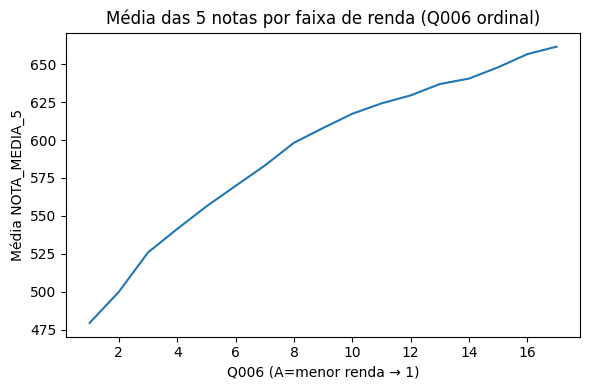

In [10]:

if "Q006" in df.columns:
    ord_map = {chr(i): i-64 for i in range(65, 91)}  # A..Z -> 1..26
    df["Q006_ord"] = df["Q006"].map(ord_map)
    trend = df.groupby("Q006_ord")["NOTA_MEDIA_5"].mean().reset_index().sort_values("Q006_ord")
    display(trend.head(12))
    plt.figure(figsize=(6,4))
    plt.plot(trend["Q006_ord"], trend["NOTA_MEDIA_5"])
    plt.title("Média das 5 notas por faixa de renda (Q006 ordinal)")
    plt.xlabel("Q006 (A=menor renda → 1)")
    plt.ylabel("Média NOTA_MEDIA_5")
    plt.tight_layout()
    plt.show()
else:
    print("Q006 não encontrado na base.")



## 9. (Opcional) Salvar amostra para depuração

Útil para compartilhar um subconjunto pequeno com colegas.


In [19]:

sample_path = "../data/interim/enem_2023_sample_1k.csv"
df.sample(min(1000, len(df)), random_state=42).to_csv(sample_path, index=False)
print("Amostra salva em:", sample_path)


Amostra salva em: ../data/interim/enem_2023_sample_1k.csv
